## Overview

This code calculates the input parameters by assimilating to the synthetic data generated using the forward model. However, only one set of soil temperature data (at 5cm) is used. The results are discussed in section 3.1 of the paper.

## Instructions

This file should be run in Google Colab.

A total of 50 trials are run. Each optimisation trial uses a different set of initial parameter values. One active session in Google Colab uses 2 CPUs, allowing a maximum of 10 trials to be run simultaneously with 5 active sessions. 

**To run the file:**
1. Upload and open the file in Google Colab.
2. Click **Files** in Google Colab and upload *Target_T2.txt* into the file storage.
3. Run the code.
4. To open another active session, save a copy of this file and open it in another tab. Adjust the trial numbers at the bottom of the code to generate the next 10 sets of initial parameter values. 


How the optimisation works is by wrapping the entire inverse model in a single function (*worker_function ()*), and running it repeating with different parameter values until the solution converges. Each iteration, the parameter values are updated using backpropagation. 

Every 5 iterations, the code will print the no. of iterations so far, current parameter values, loss, relative change in loss, and relative changes in parameter values. 

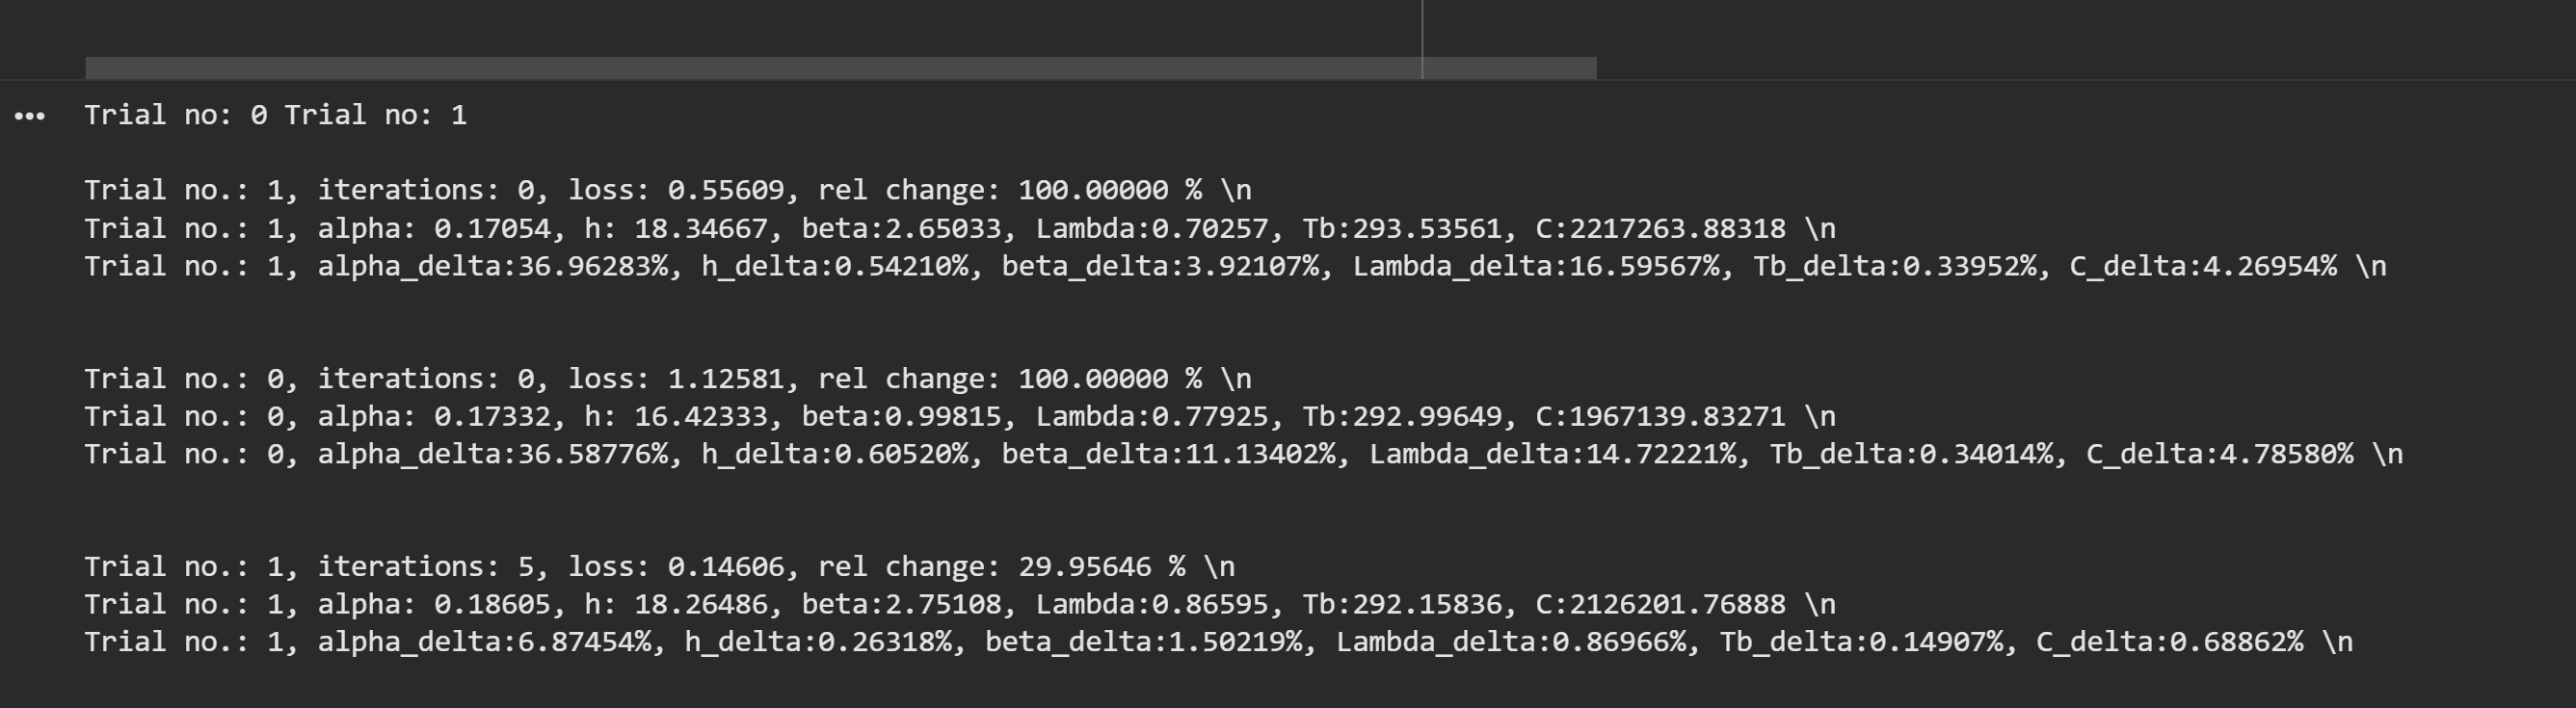

The optimisation ends (i.e. the solution is considered to have converged) when any of the three conditions are fulfilled: (i) relative change in loss is less than 0.01%, or (ii) when the maximum relative change in parameter (out of all 6 input parameters) is less than 0.1% or, or (iii) when no. of iterations exceed 150. 

In [ ]:
#-- Import general libraries
import os
import numpy as np
import pandas as pd
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import csv
import sys
import scipy
from torch.optim.lr_scheduler import StepLR

In [ ]:
import multiprocessing
import concurrent.futures


# Define the function to be executed by each process
def worker_function(x):
    start = 0
    mse_loss = nn.MSELoss()

    # Specify size of the domain
    Nx = 101
    xa = 0
    xb = 1

    # Create a meshgrid
    x_array = np.linspace(xa, xb, Nx) # np array
    dx = (xb-xa)/(Nx-1)
    depth_measurement = 0.05
    depth_i = int(np.floor(depth_measurement/dx))

    # Time setup
    hour = 3600 # no. of seconds in an hour 
    dt = hour; # length of time interval 
    Nt = 100; # no. of time intervals 
    t_total = Nt*dt; # total time 
    time = np.linspace(0, t_total,Nt+1);

    #Thermal & radiation properties
    Ta = 296 #atmospheric temperature 
    epsilon = 0.95 #emissivity 
    sigma = 5.67e-8 #Stefan-Boltzmann constant
    K_down = 800 #downwelling shortwave rodiation
    L_down = 100 #downwelling longwave radiation 
    
    #Min & Max values of parameters
    alpha0 = 0.05 #min albedo
    alpha1 = 0.5 #max albedo 
    h0 = 5 #min heat transfer coefficient 
    h1 = 20 #max heat transfer coefficient 
    beta0 = 0.5 #min Bowen Ratio 
    beta1 = 5 #max Bowen Ratio 
    C0 = 2e6 #min volumetric heat capacity 
    C1 = 2.5e6 #max volumetric heat capacity 
    Tb0 = 290 #min initial/boundary temperature 
    Tb1 = 303 #max initial/boundary temperature 
    Lambda0 = 0.47 #min thermal conductivity 
    Lambda1 = 0.8 #max thermal conductivity

    #True values
    alpha_true = 0.2
    Lambda_true = 0.8
    Tb_true = 293
    C_true = 2.2e6
    beta_true = 1.5
    h_true = 15

    class HeatEqConv(nn.Module):
        def __init__(self, Nx, filter_weight): #filter_weight
            super(HeatEqConv, self).__init__()

            # Specify the size of the input (batch_size, channels, width)
            input_size = (1, 1, Nx)  # Adjust the size based on your requirements
            batch_size, in_channels, width = input_size

            # Specify the size of the filter/kernel
            kernel_size = filter_weight.shape[2]

            # Create a Conv1d layer with the specified weight, input size, and padding
            self.conv_layer = nn.Conv1d(in_channels, out_channels=1,kernel_size=kernel_size, padding='valid', bias=False)
            self.conv_layer.weight.data = filter_weight

        def forward(self, previous):

            future = self.conv_layer(previous) # previous(1,1,Nx); future(1,1,Nx-2)
            return future

    # Convert NumPy arrays to PyTorch tensors with float type
    x_tensor = torch.tensor(np.array(x_array), dtype=torch.float64)

    # filter corresponding to the second order central difference of the second derivative
    filter = torch.tensor([1, 0., 1], dtype=torch.float64)

    # resize filter for PyTorch
    # filter_weight(num_kernels/output channels, kernel_height, kernel_width)
    filter_weight = filter.view(1, 1, filter.shape[0])

    # Create instance of convolution and use it as a function to apply convolution
    mymodel_time_march = HeatEqConv(Nx,filter_weight)

    trise = 7*hour
    tset = 21*hour

    t24 = np.mod(time, 24*hour);
    theta=(t24-trise)/(tset-trise)*np.pi/2 + (t24-tset)/(tset-trise)*np.pi/2;
    for i in range(Nt+1):
        if abs(theta[i]) > np.pi/2:
            theta[i] = theta[i]/abs(theta[i])*np.pi/2

    K_down_array = K_down*np.cos(theta)
    L_down_array = L_down*np.ones(Nt+1)
    Ta_array = Ta*np.ones(Nt+1)

    #set observations
    time = np.linspace(0, t_total,Nt+1);
    target_T5 = np.loadtxt('Target_T2.txt') # Load soil temperature data at depth 5 cm
    target_T5 = torch.tensor(target_T5, dtype=torch.float64)

    torch.manual_seed(0)
    random_no = torch.rand(50, 6)

    def forward(alpha,h,beta,C,Tb,Lambda,mymodel_time_march,Nt,start):

        Tb.retain_grad()
        h.retain_grad()
        alpha.retain_grad()
        beta.retain_grad()
        C.retain_grad()
        Lambda.retain_grad()

        T_array = torch.zeros(Nt+1,dtype=torch.float64)
        T_array[0] = Tb
        Tn1 = Tb*torch.ones(Nx,dtype=torch.float64)

        tol = 1e-4

        #Solve for temperature at measurement depth
        for t in range(start,Nt+start):
            Tn1 = HeatEqSolver(mymodel_time_march,Tn1,tol,K_down_array[t+1],L_down_array[t+1],Ta_array[t+1],alpha,h,beta,C,Tb,Lambda)
            T_array[t-start+1] = Tn1[depth_i]

        return T_array,Tn1

    def HeatEqSolver(mymodel_time_march,Tn, tol,K_down,L_down,Ta,alpha,h,beta,C,Tb,Lambda):
        error = 9e9
        # first guess
        Tn1_k = Tn
        # recalculate r
        r = Lambda/C*dt/(dx**2)
        while(error>tol):
            # Input kth approximation of Tn+1 into NN -> transform into 3D tensor
            Tn1_k_tensor= Tn1_k.view(1, 1, Nx)
            # Apply convolution to obtain (k+1)th approximation of Tn+1 for interior nodes
            Tn1_k1_tensor = 1/(1+2*r)*(r*mymodel_time_march(Tn1_k_tensor) + Tn[1:-1])
            # Calculate new Tn+1 at boundary based on Tn and kth approximation of Tn+1
            Tn1_k1_0 = 1/(1+2*r*(1+dx/Lambda*(h*(1+1/beta)+sigma*epsilon*Tn1_k[0]**3)))*(Tn[0]+2*r*(Tn1_k[1]+dx/Lambda*(K_down*(1-alpha) + L_down + h*(1+1/beta)*Ta)))
            # Append BCs
            Tn1_k1_tensor  = torch.cat((Tn1_k1_0, Tn1_k1_tensor[0,0,:], Tb),0)
            # Calculate error
            error = torch.max(torch.abs(Tn1_k1_tensor-Tn1_k))
            # Continue from (k+1)th approximation
            Tn1_k = Tn1_k1_tensor


        return Tn1_k1_tensor

    print(r'Trial no: {} '.format(x))
    #Random initialisation of parameters
    alpha = torch.tensor([alpha0+(alpha1-alpha0)*random_no[x,0]], dtype=torch.float64,requires_grad=True)
    h = torch.tensor([h0+(h1-h0)*random_no[x,1]], dtype=torch.float64,requires_grad=True)
    beta = torch.tensor([beta0+(beta1-beta0)*random_no[x,2]], dtype=torch.float64,requires_grad=True)
    C = torch.tensor([C0+(C1-C0)*random_no[x,3]], dtype=torch.float64,requires_grad=True)
    Tb = torch.tensor([Tb0+(Tb1-Tb0)*random_no[x,4]], dtype=torch.float64,requires_grad=True)
    Lambda = torch.tensor([Lambda0+(Lambda1-Lambda0)*random_no[x,5]], dtype=torch.float64,requires_grad=True)

    losses = [9e9]

    its_max = 150

    optimizer = torch.optim.Adam([{'params':[Tb]},{'params':[beta,h,alpha,Lambda], 'lr':0.1},{'params':[C], 'lr':1e5}],lr=1)

    data_values = np.zeros([2,6])
    rel_change_loss = math.inf
    delta_pp = [9e9,9e9,9e9,9e9,9e9,9e9]

    n = 0

    # For each time-step, the model computes the temperature profile and populates an empty tensor of length Nt with calculated temperature values. Loss is obtained by taking the MSE between the output and target values. 
    while max(delta_pp) > 0.1 or rel_change_loss > 0.01:
      if n == 0:
        data_values[0,:] = [alpha.item(),h.item(),beta.item(),Lambda.item(),Tb.item(),C.item()]

      optimizer.zero_grad()
      [output,Tn1] = forward(alpha,h,beta,C,Tb,Lambda,mymodel_time_march,Nt,start)
      loss = mse_loss(output,target_T5)
      alpha_prev = alpha.item()
      h_prev = h.item()
      beta_prev = beta.item()
      Lambda_prev = Lambda.item()
      Tb_prev = Tb.item()
      C_prev = C.item()

      # Backward pass to calculate gradients
      loss.backward(retain_graph=True)

      #Calculate relative % change in loss  
      rel_change_loss = abs(losses[-1]-loss.item())/losses[-1]*100

      losses.append(loss.item())

      # optimize parameters
      optimizer.step()

      #Calculate relative % change in parameter values
      delta_pp = [abs(alpha_prev-alpha.item())/alpha_prev*100,abs(h_prev-h.item())/h_prev*100,abs(beta_prev-beta.item())/beta_prev*100, abs(Lambda_prev-Lambda.item())/Lambda_prev*100,abs(Tb_prev-Tb.item())/Tb_prev*100,abs(C_prev-C.item())/C_prev*100]

      if n%5 == 0:
        print(r'Trial no.: {}, iterations: {}, loss: {:.5f}, rel change: {:.5f} % \n'.format(x,n,loss.item(),rel_change_loss))
        print(r'Trial no.: {}, alpha: {:.5f}, h: {:.5f}, beta:{:.5f}, Lambda:{:.5f}, Tb:{:.5f}, C:{:.5f} \n'.format(x,alpha.item(),h.item(),beta.item(),Lambda.item(),Tb.item(),C.item()))
        print(r'Trial no.: {}, alpha_delta:{:.5f}%, h_delta:{:.5f}%, beta_delta:{:.5f}%, Lambda_delta:{:.5f}%, Tb_delta:{:.5f}%, C_delta:{:.5f}% \n'.format(x,delta_pp[0],delta_pp[1],delta_pp[2],delta_pp[3],delta_pp[4],delta_pp[5]))
        print('\n')

      # End Oprimisation if no. of iteration > its_max  
      n = n+1
      if n > its_max:
        break

    data_values[1,:] = [alpha.item(),h.item(),beta.item(),Lambda.item(),Tb.item(),C.item()]

    return(data_values)

if __name__ == '__main__':

    with concurrent.futures.ProcessPoolExecutor(max_workers=2) as executor:
      inputs = list(range(10)) #first 10 trials
      # to change to inputs = list(range(10,20)) for the next 10 trials, list(range(20,30)) for the next 10 etc. The last one, for a total of 50 trials, will be list(range(40,50))
      resultsi = executor.map(worker_function, inputs)



In [ ]:
#Convert results to a list 
results_temp = list(resultsi)

In [ ]:
# Download the final parameter values 
with open('final_parameter_values_1depth_1.txt','w') as outfile: # To rename the txt file for the next 10 trials. 
  for trial_no in range(10): # to change to range(10,20) for the next 10 trials, list(range(20,30)) for the next 10 etc. 
    outfile.write('#Trial no.{}\n'.format([trial_no]))
    np.savetxt(outfile,results_temp[trial_no],fmt='%-7.5e')

from google.colab import files
files.download('final_parameter_values_1depth_1.txt') # To rename the txt file for the next 10 trials. 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>